In [66]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import snowballstemmer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud

import nltk

nltk.download('punkt')
nltk.download('stopwords')

stemmer = snowballstemmer.stemmer('english')

nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edlich\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edlich\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\edlich\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Preparation and Exploitative Data Analysis

## Dataset Properties

In [42]:
data = pd.read_csv('data/all.csv', encoding='utf-8')
data.head()

,site,date,stars,title,text,location
0,nordvpn.com,2023-01-14T07:13:59.000Z,1,Had 5G speed plummet from 400mbps down…,With just one device connected 4G+ speed 90mbp...,GB
1,nordvpn.com,2023-01-12T18:22:21.000Z,1,Very Slow,Very Slow - avoid this company Recently signed...,CA
2,nordvpn.com,2023-01-11T19:04:20.000Z,2,Underwhelming service and functionality,I have been using the service for about 3 mont...,DK
3,nordvpn.com,2023-01-11T21:11:06.000Z,1,I can't wait to switch VPNs,I can't wait to switch VPNs. Every time my PC ...,CA
4,nordvpn.com,2023-01-10T20:23:31.000Z,1,Horrible,Horrible. Beware!! I signed up and after m...,US


In [43]:
data.shape

(46746, 6)

In [44]:
data.nunique()

site           11
date        46722
stars           5
title       42350
text        44911
location      188
dtype: int64

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46746 entries, 0 to 46745
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   site      46746 non-null  object
 1   date      46746 non-null  object
 2   stars     46746 non-null  int64 
 3   title     46746 non-null  object
 4   text      46746 non-null  object
 5   location  46740 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB


<AxesSubplot: >

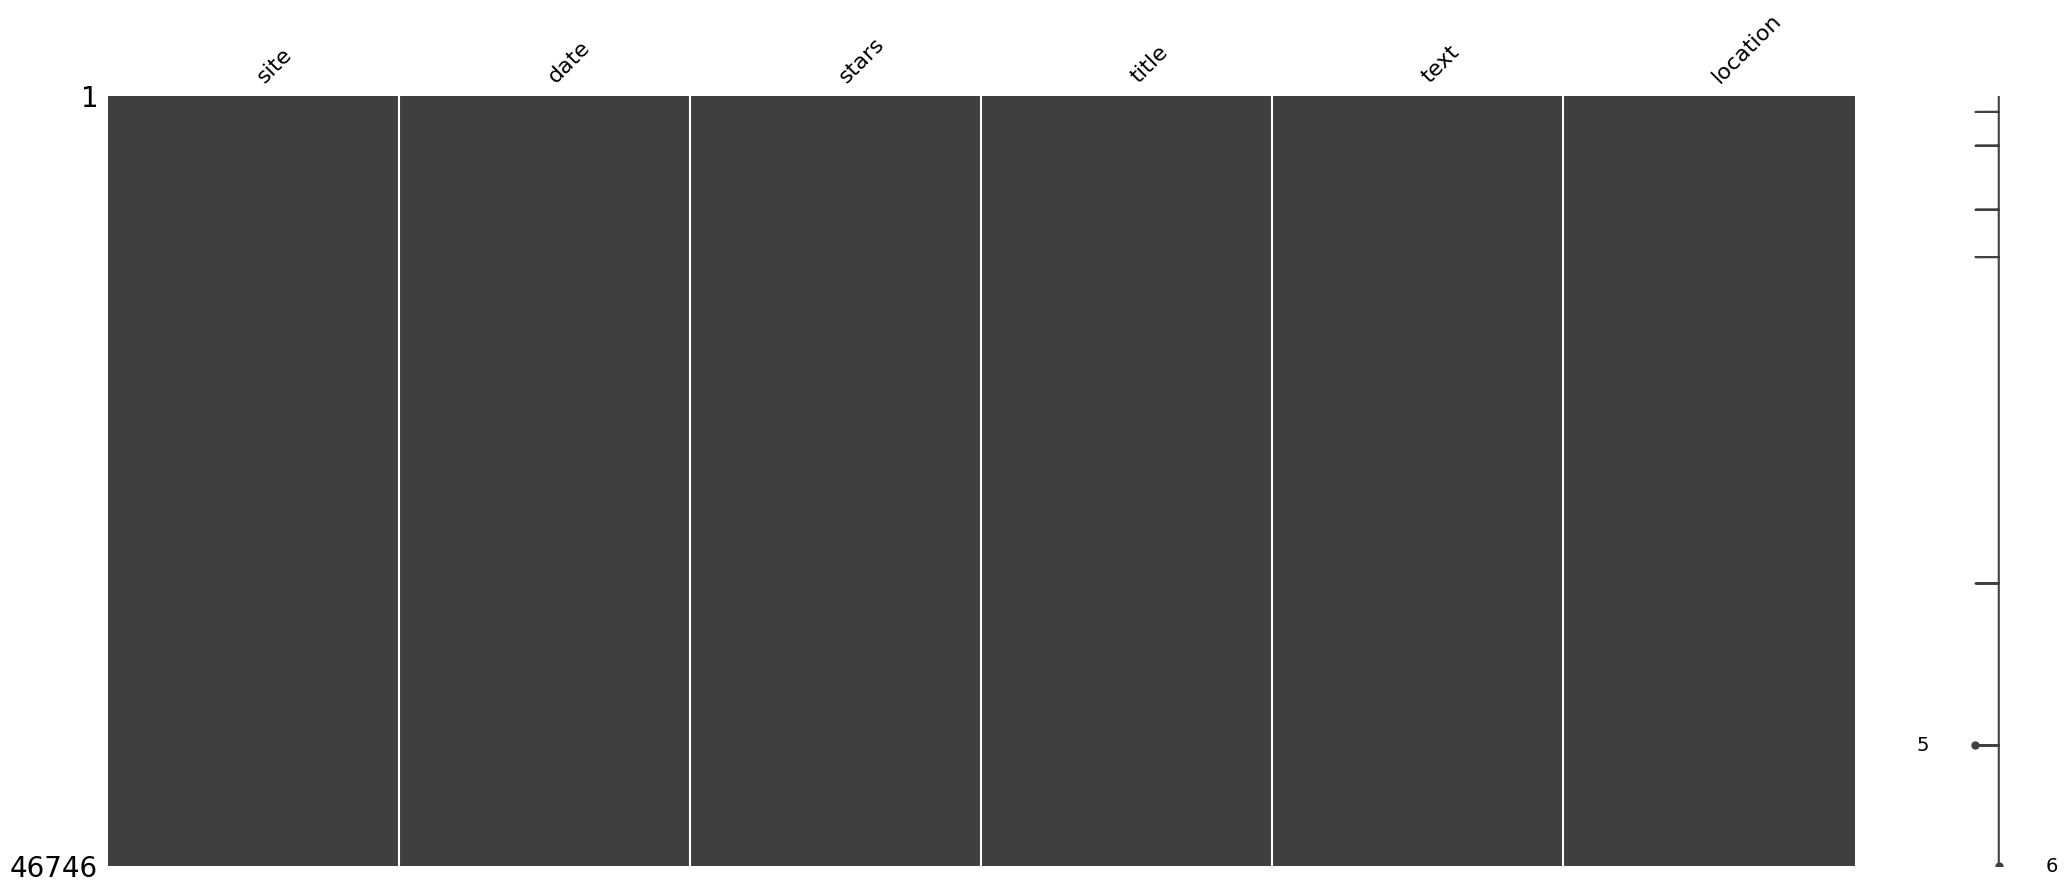

In [46]:
msno.matrix(data)

In [47]:
data.drop(['site', 'date', 'location'], inplace=True, axis=1)
data.head()

,stars,title,text
0,1,Had 5G speed plummet from 400mbps down…,With just one device connected 4G+ speed 90mbp...
1,1,Very Slow,Very Slow - avoid this company Recently signed...
2,2,Underwhelming service and functionality,I have been using the service for about 3 mont...
3,1,I can't wait to switch VPNs,I can't wait to switch VPNs. Every time my PC ...
4,1,Horrible,Horrible. Beware!! I signed up and after m...


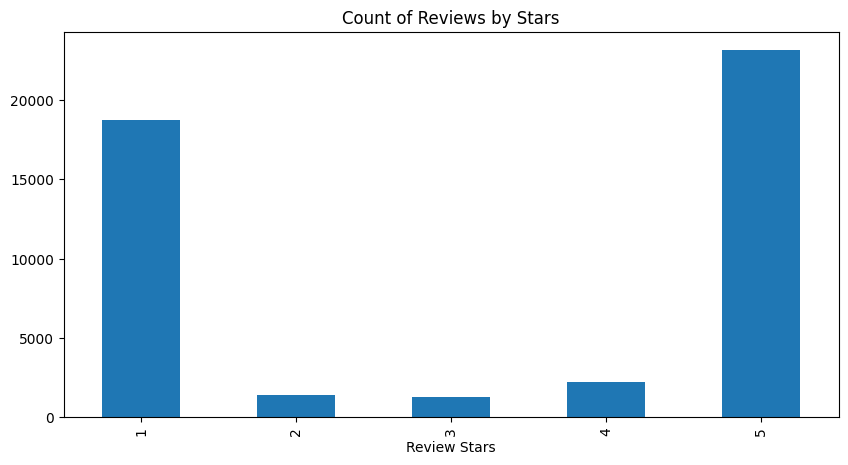

In [48]:
ax = data['stars'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Cleaning

In [49]:
stp_words = stopwords.words('english')


def clean_text(text):
    # No data
    if text.startswith('Date of experience:'):
        return np.nan

    text = text.lower()

    text = re.sub('\\\\', ' ', text)  # removal of escaped escape

    # replace single quotes
    text = re.sub(r"\[\'", '["', text)
    text = re.sub(r"\']", '"]', text)

    text = re.sub(r"(\', )", '", ', text)
    text = re.sub(r"(, \')", ', "', text)

    #  remove links
    text = re.sub(r"https?:\/\/[a-zA-Z0-9,.\/?#:\-_.~&]*", ' ', text)

    # remove emojis | source: https://stackoverflow.com/a/49146722
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # remove stopwords, numbers and punctuation
    text = ' '.join(word.strip(string.punctuation) for word in text.split() if
                    (word not in stp_words) or (not any(c.isdigit() for c in word)))

    text = re.sub(r'\s+', ' ', text)  # removal of multiple spaces

    # stem text
    text = " ".join(stemmer.stemWords(text.split()))

    if len(text) == 0:
        return np.nan

    return text

In [50]:
data['text_clean'] = data['text'].apply(clean_text)

## Dataset Properties after Cleaning

<AxesSubplot: >

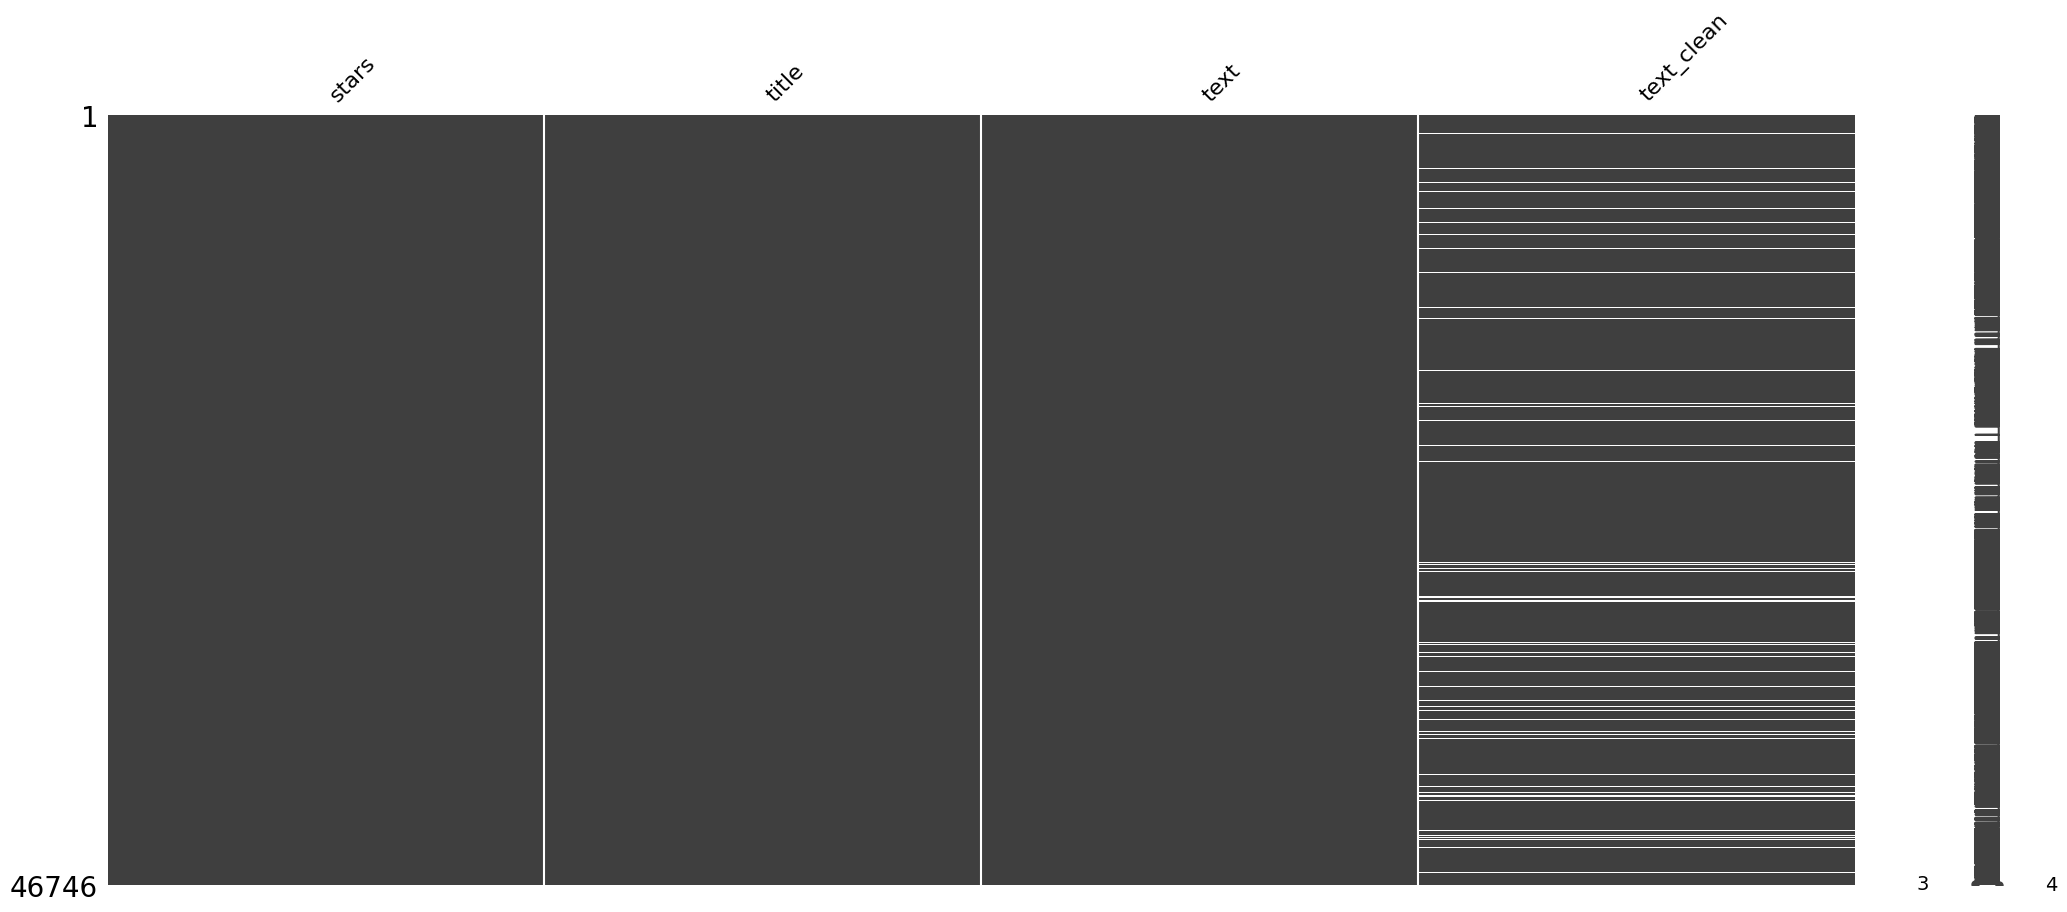

In [51]:
msno.matrix(data)

In [52]:
print(f'{data["text_clean"].isna().sum()} NaN values found')

2751 NaN values found


In [53]:
# drop empty columns after preprocessing
data.dropna(inplace=True)
data.shape

(43995, 4)

In [54]:
print(f'{data["text_clean"].isna().sum()} NaN values found')

0 NaN values found


#### Classification: Rating - Sentiment

In [55]:
data.loc[data['stars'] == 1, 'sentiment'] = 'negative'
data.loc[data['stars'] == 5, 'sentiment'] = 'positive'
data.loc[data['stars'].between(2, 4), 'sentiment'] = 'neutral'

In [56]:
data.groupby('sentiment')['sentiment'].count()

sentiment
negative    18129
neutral      4518
positive    21348
Name: sentiment, dtype: int64

#### Equal sized Classes

In [57]:
data = data.groupby('sentiment').head(
    data.groupby('sentiment')['sentiment'].count().min())

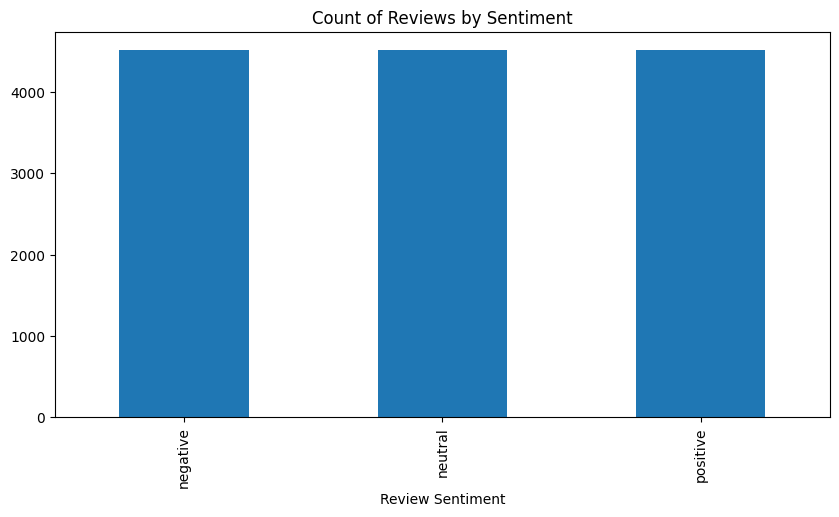

In [58]:
data = data.groupby('sentiment').head(
    data.groupby('sentiment')['sentiment'].count().min())
# show a plot of the number of reviews for each sentiment
ax = data['sentiment'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment',
          figsize=(10, 5))
ax.set_xlabel('Review Sentiment')
plt.show()

### WordCloud

In [59]:
def print_wordCloud(category, text):
    print(category)
    wordcloud = WordCloud(width=400, height=400,
                          background_color='white',
                          min_font_size=10).generate(text)
    plt.figure(figsize=(7, 7), facecolor='white', edgecolor='blue')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


def make_string(category):
    post_comments_str = ""
    for row_index, row in data[data['sentiment'] == category].iterrows():
        post_comments_str += " " + row['text_clean']
    return post_comments_str

negative


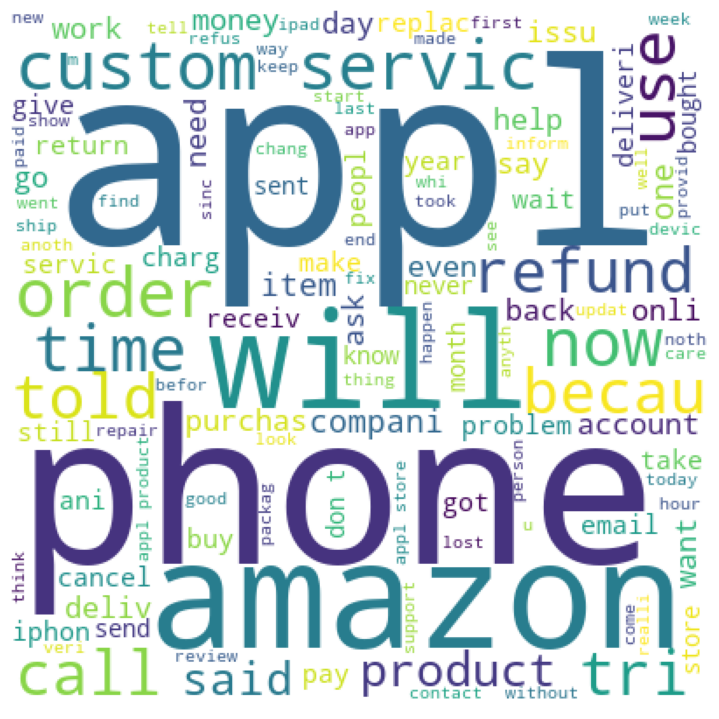

neutral


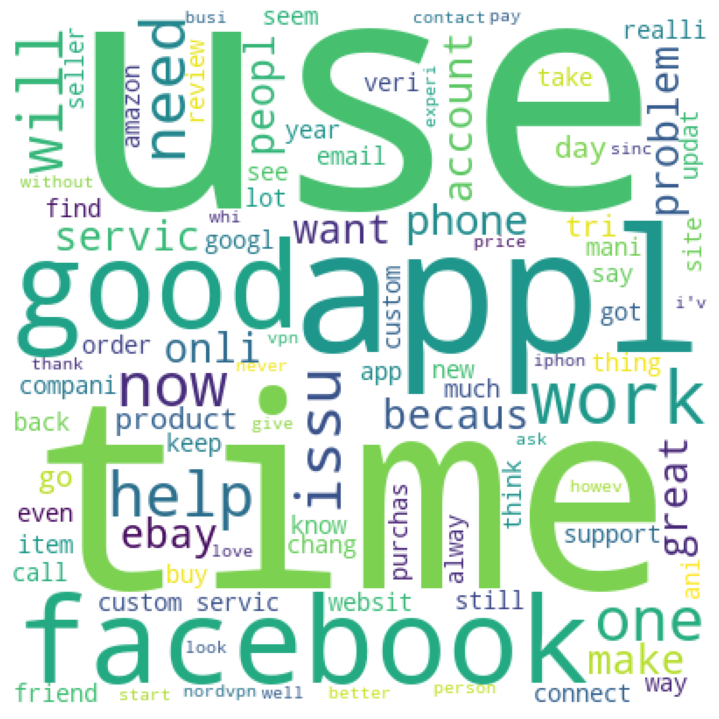

positive


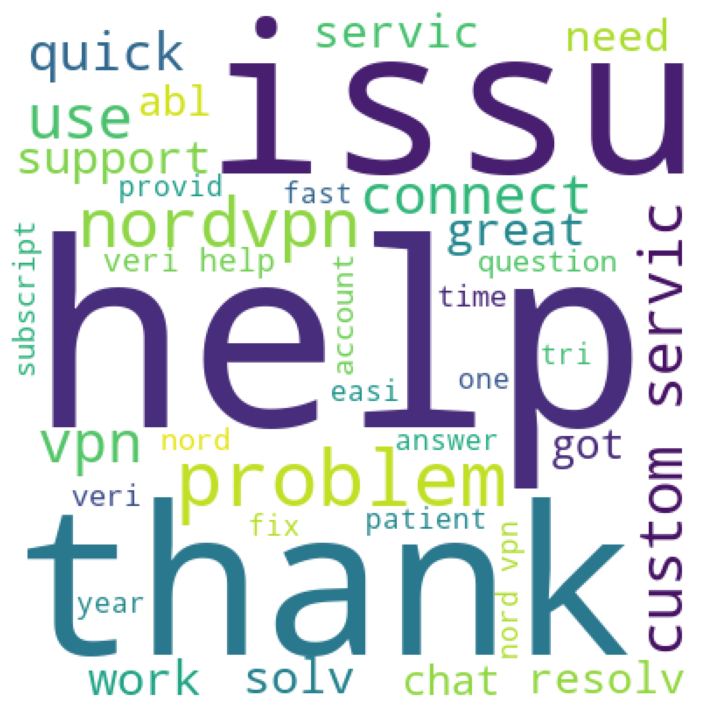

In [60]:
sentiment_list = data['sentiment'].unique().tolist()

for s in sentiment_list:
    sentiment_text = make_string(s)
    print_wordCloud(s, sentiment_text)

## Sentiment Analysis

### VADER

In [61]:
sid_vader = SentimentIntensityAnalyzer()

In [62]:
data['text_sid_vader'] = data['text_clean'].apply(
    lambda content: sid_vader.polarity_scores(content))

# split vader score into independent columns
data = pd.concat([data.drop(['text_sid_vader'], axis=1), data['text_sid_vader'].apply(lambda value: pd.Series(value).rename(index={
                 'neg': 'text_sid_vader_neg', 'neu': 'text_sid_vader_neu', 'pos': 'text_sid_vader_pos', 'compound': 'text_sid_vader_compound'}))], axis=1)

#### Plot VADER results - Score/Stars vs. Score/Classes

##### Barplot

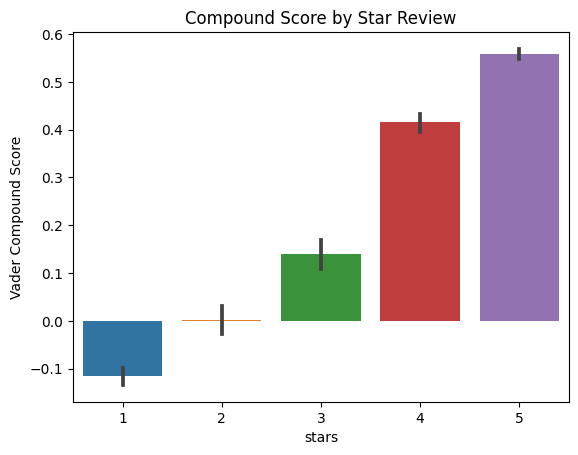

In [68]:
ax = sns.barplot(data=data, x='stars', y='text_sid_vader_compound')
ax.set_title('Compound Score by Star Review')
ax.set_ylabel('Vader Compound Score')
plt.show()

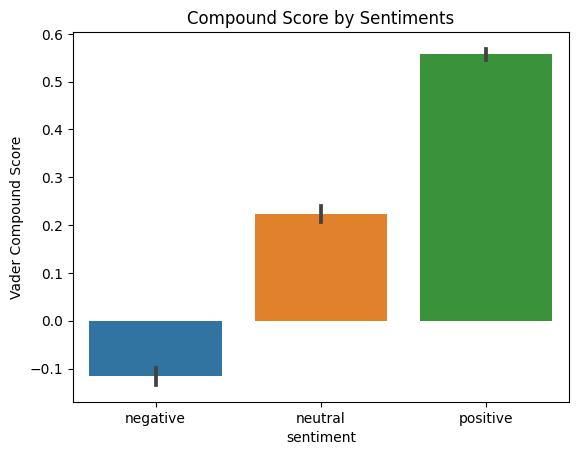

In [69]:
ax = sns.barplot(data=data, x='sentiment', y='text_sid_vader_compound')
ax.set_title('Compound Score by Sentiments')
ax.set_ylabel('Vader Compound Score')
plt.show()

##### Boxplot and Quartile

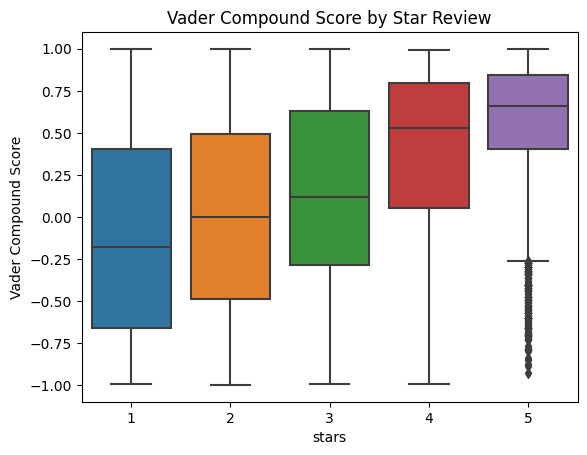

In [70]:
ax = sns.boxplot(data=data, x='stars', y='text_sid_vader_compound')
ax.set_title('Vader Compound Score by Star Review')
ax.set_ylabel('Vader Compound Score')
plt.show()

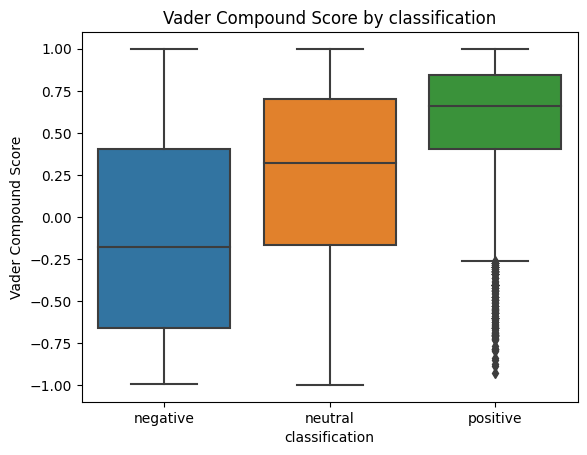

In [71]:
ax = sns.boxplot(data=data, x='sentiment', y='text_sid_vader_compound')
ax.set_title('Vader Compound Score by classification')
ax.set_ylabel('Vader Compound Score')
ax.set_xlabel('classification')
plt.show()

In [72]:
data.groupby('stars')['text_sid_vader_compound'].describe()

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1,4518.0,-0.116150,0.597880,-0.9937,-0.65970,-0.1779,0.401900,0.9989
2,1291.0,0.001164,0.570040,-0.9979,-0.48945,0.0000,0.493900,0.9961
3,1202.0,0.139855,0.543363,-0.9917,-0.28585,0.1217,0.631000,0.9962
4,2025.0,0.415045,0.454960,-0.9929,0.05160,0.5267,0.796400,0.9923
5,4518.0,0.557578,0.370003,-0.9287,0.40190,0.6597,0.845725,0.9966


In [73]:
data.groupby('sentiment')['text_sid_vader_compound'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
negative,4518.0,-0.116150,0.597880,-0.9937,-0.6597,-0.1779,0.401900,0.9989
neutral,4518.0,0.223567,0.544507,-0.9979,-0.1685,0.3217,0.700825,0.9962
positive,4518.0,0.557578,0.370003,-0.9287,0.4019,0.6597,0.845725,0.9966


##### Correlation Sentiment and Rating

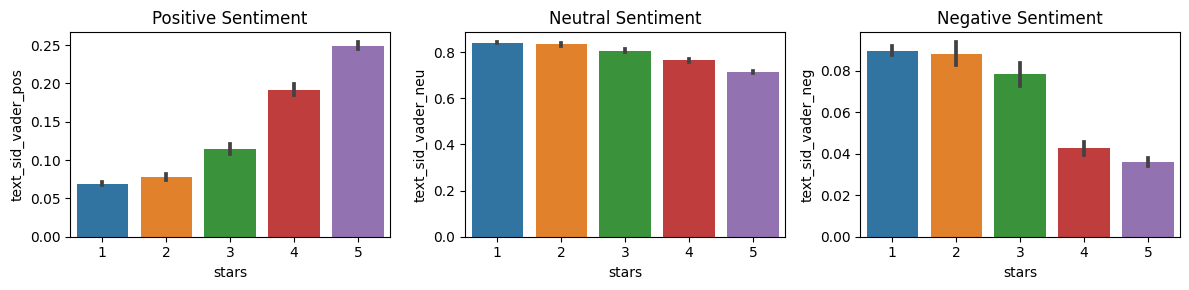

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=data, x='stars', y='text_sid_vader_pos', ax=axs[0])
sns.barplot(data=data, x='stars', y='text_sid_vader_neu', ax=axs[1])
sns.barplot(data=data, x='stars', y='text_sid_vader_neg', ax=axs[2])
axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')
plt.tight_layout()
plt.show()

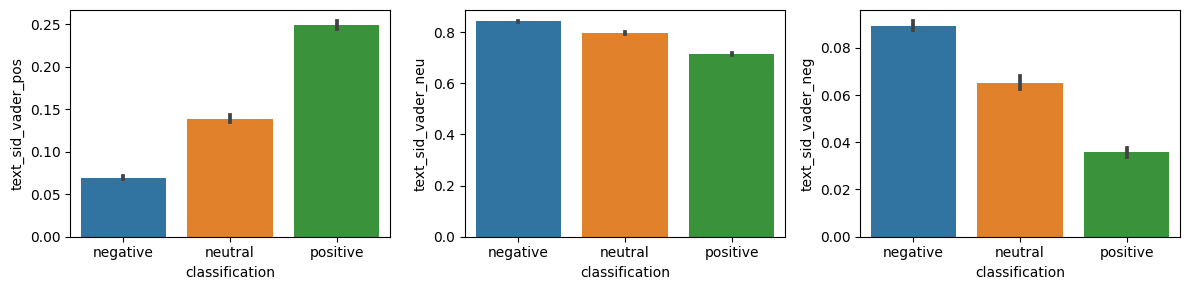

In [75]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=data, x='sentiment', y='text_sid_vader_pos', ax=axs[0])
sns.barplot(data=data, x='sentiment', y='text_sid_vader_neu', ax=axs[1])
sns.barplot(data=data, x='sentiment', y='text_sid_vader_neg', ax=axs[2])
axs[0].set_xlabel('classification')
axs[1].set_xlabel('classification')
axs[2].set_xlabel('classification')
plt.tight_layout()
plt.show()

### TextBlob

In [76]:
data['text_sid_textblob_polarity'] = data['text_clean'].apply(
    lambda content: TextBlob(content).sentiment.polarity)

##### Barplot

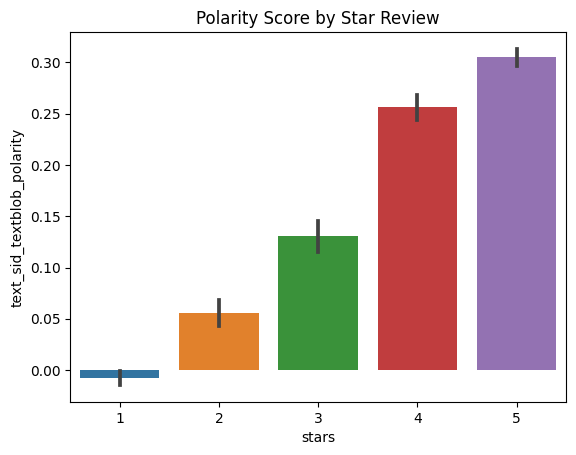

In [77]:
ax = sns.barplot(data=data, x='stars', y='text_sid_textblob_polarity')
ax.set_title('Polarity Score by Star Review')
plt.show()

##### Boxplot and Quartile

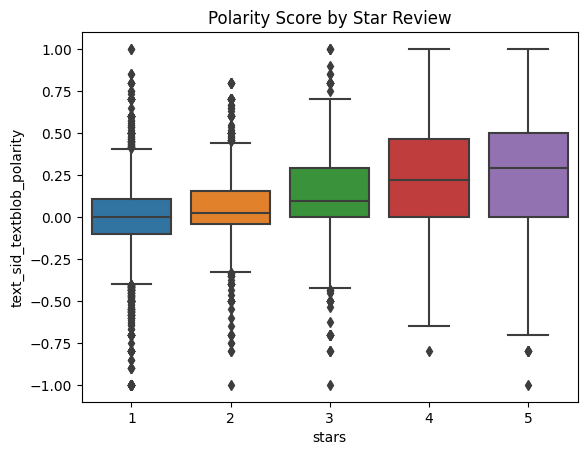

In [78]:
ax = sns.boxplot(data=data, x='stars', y='text_sid_textblob_polarity')
ax.set_title('Polarity Score by Star Review')
plt.show()

In [79]:
data.groupby('stars')['text_sid_textblob_polarity'].describe()

,count,mean,std,min,25%,50%,75%,max
stars,,,,,,,,
1,4518.0,-0.007768,0.229386,-1.0,-0.098795,0.000000,0.104256,1.0
2,1291.0,0.055340,0.223115,-1.0,-0.040455,0.025000,0.154419,0.8
3,1202.0,0.130262,0.271515,-1.0,0.000000,0.093809,0.288542,1.0
4,2025.0,0.256204,0.283480,-0.8,0.000000,0.220000,0.466667,1.0
5,4518.0,0.305047,0.291607,-1.0,0.000000,0.289394,0.500000,1.0


# Export

In [ ]:
# uncomment if result should be exported
# data.to_csv('data/all_cleaned.csv', index=False)